In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from scipy import interp
from sklearn.model_selection import KFold
from pylab import rcParams
import os
os.chdir('/home/roman/Documents/Projects/Cost_Sensitive')
import eval_results

In [2]:
# ---------- Prepare and load data ---------- #
data = pd.read_csv('data/creditcard.csv')
y = data.iloc[:, -1]
n_splits = 5
kf = KFold(n_splits=n_splits, random_state=123, shuffle=True)
kf.get_n_splits(y)
y_train_l, y_test_l = [], []
for train_index, test_index in kf.split(y):
    y_train_l.append(y.iloc[train_index])
    y_test_l.append(y.iloc[test_index])

# load results and cost matrix:
y_pred_test_lr = np.load('results/y_pred_test_lr.npy')
y_pred_test_lr_probas = np.load('results/y_pred_test_lr_probas.npy')
y_pred_test_ann = np.load('results/y_pred_test_ann.npy')
y_pred_test_ann_probas = np.load('results/y_pred_test_ann_probas.npy')
y_pred_test_ann_cs = np.load('results/y_pred_test_ann_cs.npy')
y_pred_test_ann_cs_probas = np.load('results/y_pred_test_ann_cs_probas.npy')
y_pred_test_lr_mc = np.load('results/y_pred_test_lr_mc.npy')
y_pred_test_ann_mc = np.load('results/y_pred_test_ann_mc.npy')
cost_mat_test_l = np.load('results/cost_mat_test_l.npy')

In [3]:
# ---------- Define functions ---------- #
# stack y_pred arrays to 2D (proba, 1-proba):
def stack_y_probas(y_proba):
    y_proba = np.hstack((y_proba, 1 - y_proba))
    return np.array([y_proba[:int(y_proba.shape[0]/2)], y_proba[int(y_proba.shape[0]/2):]]).T

def create_roc_auc(y_true, y_pred):
    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc

# Create mean roc_auc for list of CV results:
def create_mean_roc_auc(y_true_l, y_pred_l):
    fpr_l, tpr_l, roc_auc_l, tprs_l = [], [], [], []
    mean_fpr = np.linspace(0, 1, 100)
    for y_true, y_pred in zip(y_true_l, y_pred_l):
        fpr, tpr, roc_auc = create_roc_auc(y_true, y_pred)
        tprs_l.append(interp(mean_fpr, fpr[1], tpr[1]))
        tprs_l[-1][0] = 0.0
        roc_auc_l.append(roc_auc)
    mean_tpr = np.mean(tprs_l, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    return mean_fpr, mean_tpr, mean_auc

In [4]:
# transform data to right format
y_test_2D = []
for y_test in y_test_l:
    y_test = LabelBinarizer().fit_transform(y_test)
    y_test = np.hstack((y_test, 1 - y_test))
    y_test_2D.append(y_test)
y_pred_test_lr_probas_2D, y_pred_test_ann_probas_2D, y_pred_test_ann_cs_probas_2D = [], [], []
for i in range(n_splits):
    y_pred_test_lr_probas_2D.append(stack_y_probas(y_pred_test_lr_probas[i]))
    y_pred_test_ann_probas_2D.append(stack_y_probas(y_pred_test_ann_probas[i]))
    y_pred_test_ann_cs_probas_2D.append(stack_y_probas(y_pred_test_ann_cs_probas[i].reshape(-1)))

# calculate mean curves:
mean_fpr_lr, mean_tpr_lr, mean_auc_lr = create_mean_roc_auc(y_test_2D, y_pred_test_lr_probas_2D)
mean_fpr_ann, mean_tpr_ann, mean_auc_ann = create_mean_roc_auc(y_test_2D, y_pred_test_ann_probas_2D)
mean_fpr_ann_cs, mean_tpr_ann_cs, mean_auc_ann_cs = \
    create_mean_roc_auc(y_test_2D, y_pred_test_ann_cs_probas_2D)

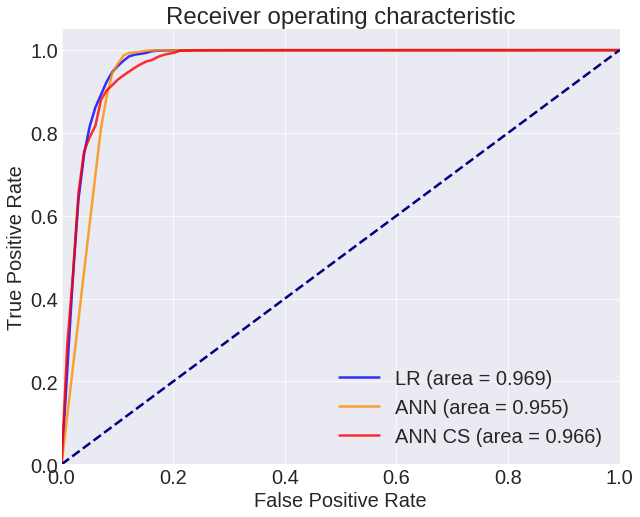

In [5]:
# Plot ROC curve
lw = 2.5
alpha = 0.8
plt.rcParams.update({'font.size': 20, 'figure.figsize': [10,8]})
plt.style.use('seaborn-darkgrid')
plt.plot(mean_fpr_lr, mean_tpr_lr, color='blue', lw=lw, alpha=alpha, \
         label='LR (area = %0.3f)' % mean_auc_lr)
plt.plot(mean_fpr_ann, mean_tpr_ann, color='darkorange', lw=lw, alpha=alpha, \
         label='ANN (area = %0.3f)' % mean_auc_ann)
plt.plot(mean_fpr_ann_cs, mean_tpr_ann_cs, color='red', lw=lw, alpha=alpha, \
         label='ANN CS (area = %0.3f)' % mean_auc_ann_cs)
        
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [14]:
f1_lr, cs_lr = eval_results.scores_and_costs(y_test_l, y_pred_test_lr, cost_mat_test_l)
f1_ann, cs_ann = eval_results.scores_and_costs(y_test_l, y_pred_test_ann, cost_mat_test_l)
f1_ann_cs, cs_ann_cs = eval_results.scores_and_costs(y_test_l, y_pred_test_ann_cs, cost_mat_test_l)
f1_lr_mc, cs_lr_mc = eval_results.scores_and_costs(y_test_l, y_pred_test_lr_mc, cost_mat_test_l)
f1_ann_mc, cs_ann_mc = eval_results.scores_and_costs(y_test_l, y_pred_test_ann_mc, cost_mat_test_l)


In [38]:
df_results = pd.DataFrame(np.array([[np.mean(cs_lr), np.mean(f1_lr)], [np.mean(cs_ann), np.mean(f1_ann)], \
                      [np.mean(cs_ann_cs), np.mean(f1_ann_cs)], [np.mean(cs_lr_mc), np.mean(f1_lr_mc)], \
                      [np.mean(cs_ann_mc), np.mean(f1_ann_mc)]]))

In [59]:
df_results.index = ['LR - Regular','ANN - Regular','ANN - Cost Sensitive', \
                    'LR - Cost classification','ANN - Cost classification']
df_results.columns = ['Cost Savings', 'F1 Score']

In [41]:
df_results

,Cost Savings,F1 Score
Logistic Regression,0.4820,0.7290
ANN Regular,0.6718,0.8022
ANN Cost Sensitive,0.7248,0.7508
LR Cost classification,0.7408,0.3318
ANN Cost classification,0.7746,0.3772


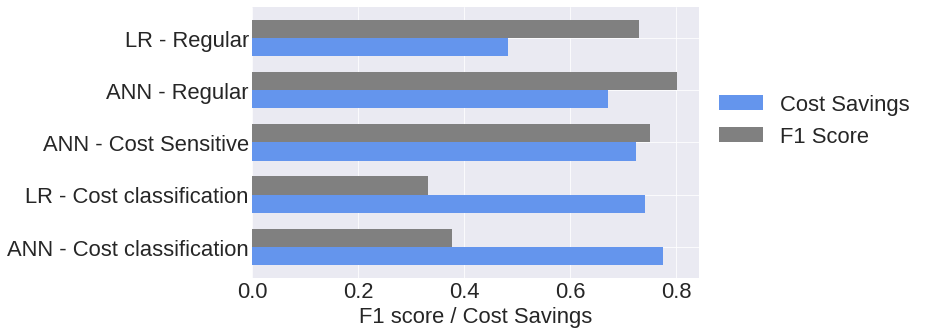

In [61]:
fig, ax = plt.subplots()
plt.rcParams.update({'figure.figsize': [8, 5], 'font.size': 22})

ax = df_results[::-1].plot.barh(ax=ax, color=['cornflowerblue', 'gray'], width=0.7)
ax.legend(bbox_to_anchor=(1, 0.75))
ax.set_xlabel('F1 score / Cost Savings')
plt.show()

In [ ]:
#np.interp([1,2,3,4,5],[3,3.5,2,2.5,1],2.33,'linear')
interp(2.33,[1,2,3,4,5],[3,3.5,2,2,1])